In [135]:

from email.mime.text import MIMEText
import smtplib, ssl
from smtplib import SMTP   
from email.mime.multipart import MIMEMultipart # sending email
from email.mime.text import MIMEText  # constructing messages
from jinja2 import Environment        # Jinja2 templating\

import numpy as np
import afinn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyhive import hive
import datetime

In [2]:

# me = "irenee.jy93@daou.co.kr"
# you = "irenee.jy93@daou.co.kr"
# password = 'hey@2020251'

# message = MIMEMultipart("alternative")
# message["Subject"] = "multipart test"
# message["From"] = me
# message["To"] = you


In [ ]:

newscard = f"""<div class="card">
                    <div class="titlesearch"><a href=\"{url}\">{title}</a></div>
                    <div class="textsearch">{summary}</div>
                    <div style="float:left;"><span class="bottomticker">{STK}</span><span class="bottomsearchtext"> {host} | {pubdate} </span></div>
                    <div style="text-align:right;"><span style="font-size:0.9rem;color:{color}; line-height:1rem ">{polarity}</span></div>
                </div>"""
stockcard =f"""  <div style="font-family:Helvetica;font-size:16px;background-color:#F3F3F3;display: inline-block;">{name}</div>
                            <div class="newsbox">
                                <div class="card-items">
                                                        {newscard}

                                                    </div>
                            </div>

                            <div><br><hr style="width=80%;size=1px;opacity:0.2; background-color:#D3D3D3;border: 0 ;"/></div>"""
newsectionhtml=f"""<div style="text-align: center;">{stockcard}
                            </div>"""

In [89]:
ttt = 'select substr(pubdate, 0,8) as dt, count(*) as qty from nutch_ext group by substr(pubdate, 0,8)'

In [90]:
conn = hive.Connection(host ='daou-bd-r01a01', port = 10000)
cursor = conn.cursor()
cursor.execute(ttt)
countnuews = cursor.fetchall()

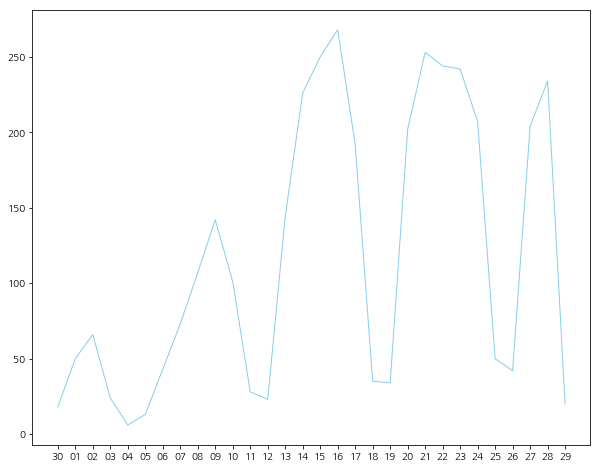

In [136]:
df = pd.DataFrame(countnuews, columns=['date', 'qty'])
dailyqty= df.sort_values(['date'],ascending=True)[-30:]
dailyqty['date'] = [a[6:8] for a in dailyqty['date']]

plt.figure(figsize=(10,8))
plt.plot( 'date', 'qty', data=dailyqty,  color='skyblue', linewidth=1)

plt.savefig('dailynewscount.png', bbox_inches='tight')



In [ ]:
dhk= 'dhkdn9192@daou.co.kr'
tjn = 'cgkim@daou.co.kr'

In [3]:
stock_lists = {'aapl':'APPLE, Inc.',
               'msft':'Microsoft Corporation',
               'amzn':'Amazon.com, Inc.',
               'baba':'Alibaba Group Holding Limited',
               'fb':'Facebook, Inc.'
               ,
               'googl':'Alphabet Inc.',
               'jnj':'Johnson & Johnson',
               'wmt':'Walmart Inc. ',
               'v':'Visa Inc.',
               'ma':'Mastercard Incorporated'
              }
selectedcol = ['pubdate','title','url','summary','score','host']+list(stock_lists.keys())

In [345]:
def make_polplot(news_list):
    timeman = pd.DataFrame([a['polarity']for a in news_list],[a['pubdate'] for a in news_list]).reset_index().rename(columns={'index':'date',0:'polarity'})
    timeman = timeman[timeman['date'] >= datetime.datetime.today() - datetime.timedelta(days = 10)]

    timeman['date']=[a.strftime('%Y%m%d')[4:6]+'/'+a.strftime('%Y%m%d')[6:8] for a in timeman['date']]
    timeman =pd.DataFrame(timeman.groupby(['date','polarity']).size()).rename(columns={0:'cnt'}).reset_index()
    plt.figure(figsize=(16,10))
    sns.barplot(x="date", y="cnt", hue="polarity", data=timeman,palette="Blues_d")
    plt.savefig(f'polarity_{STK}.png', bbox_inches='tight')


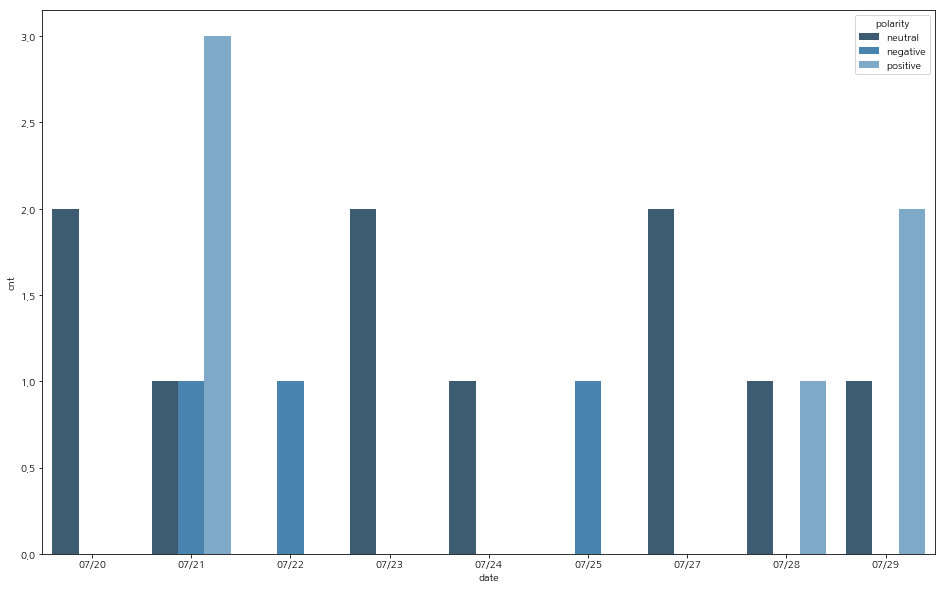

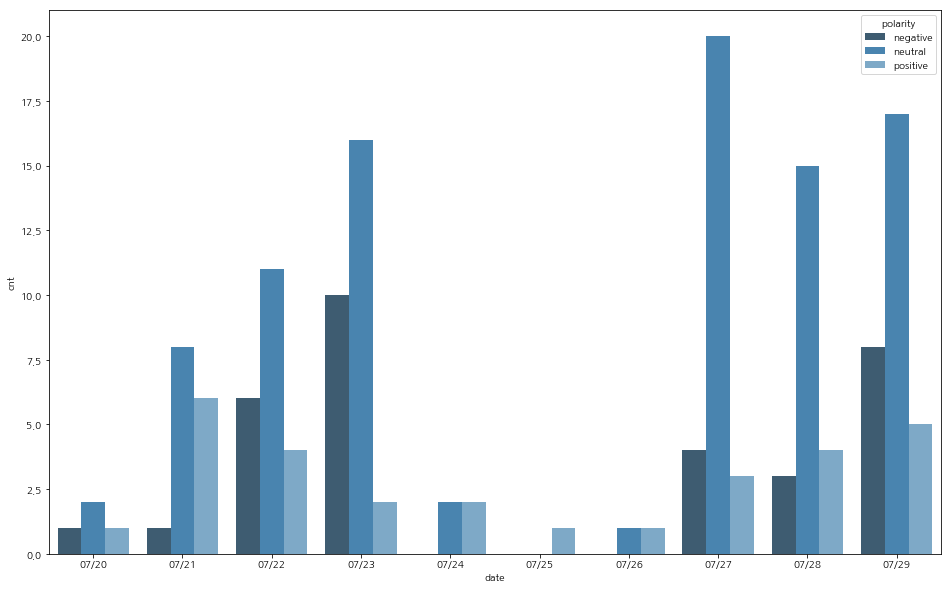

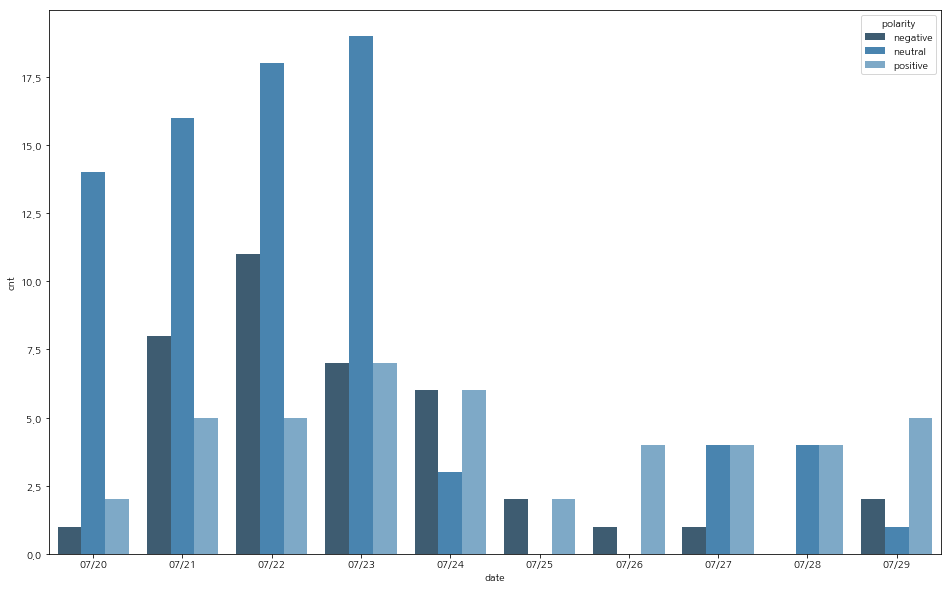

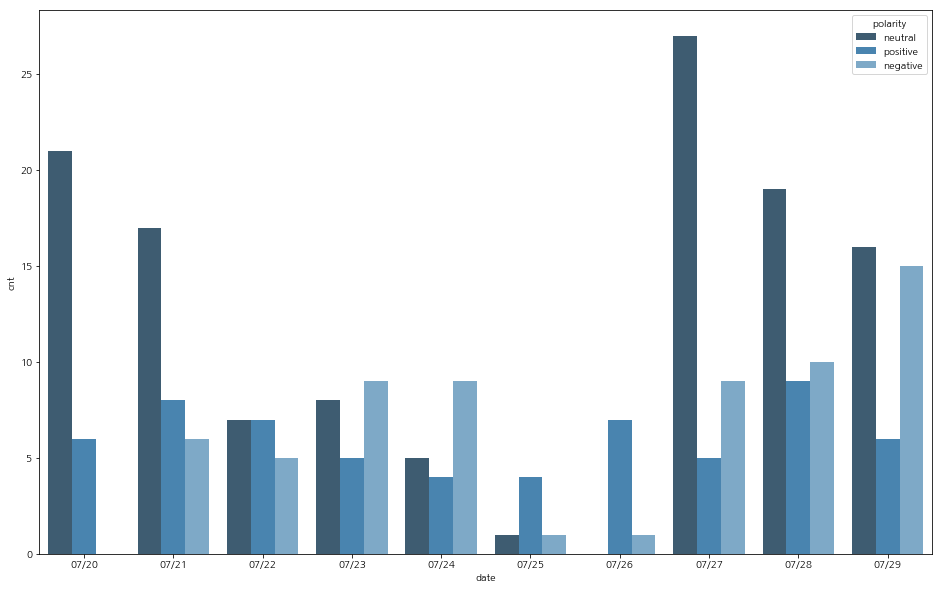

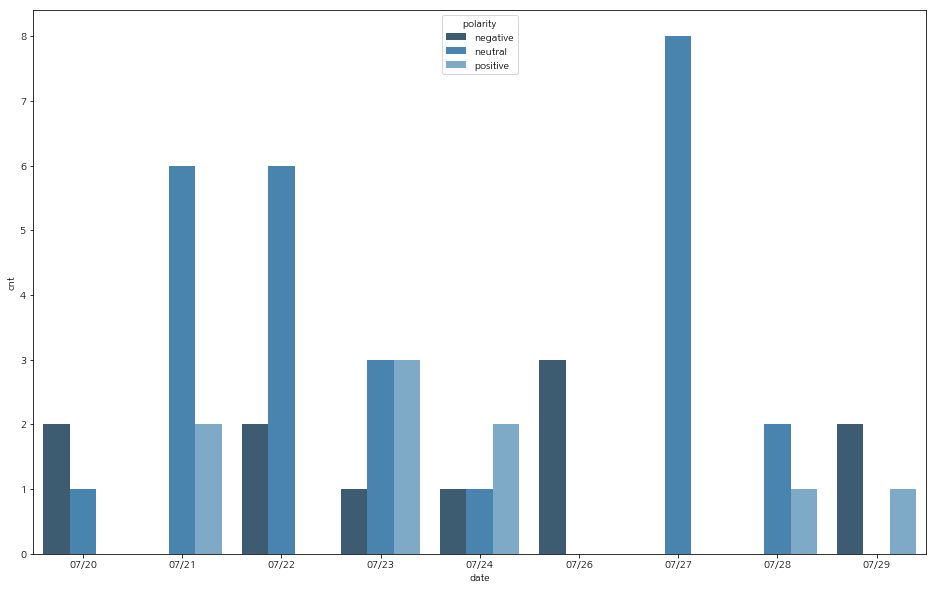

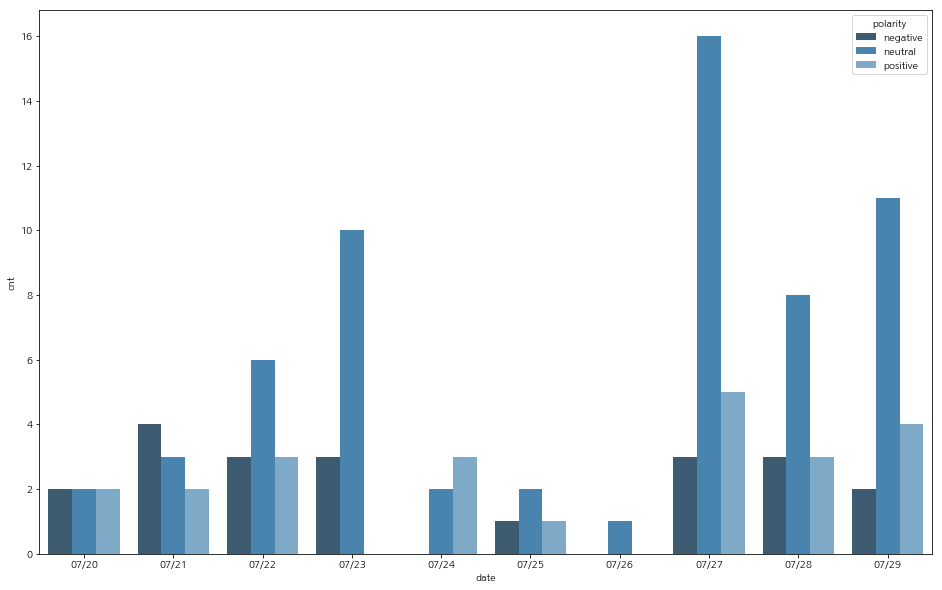

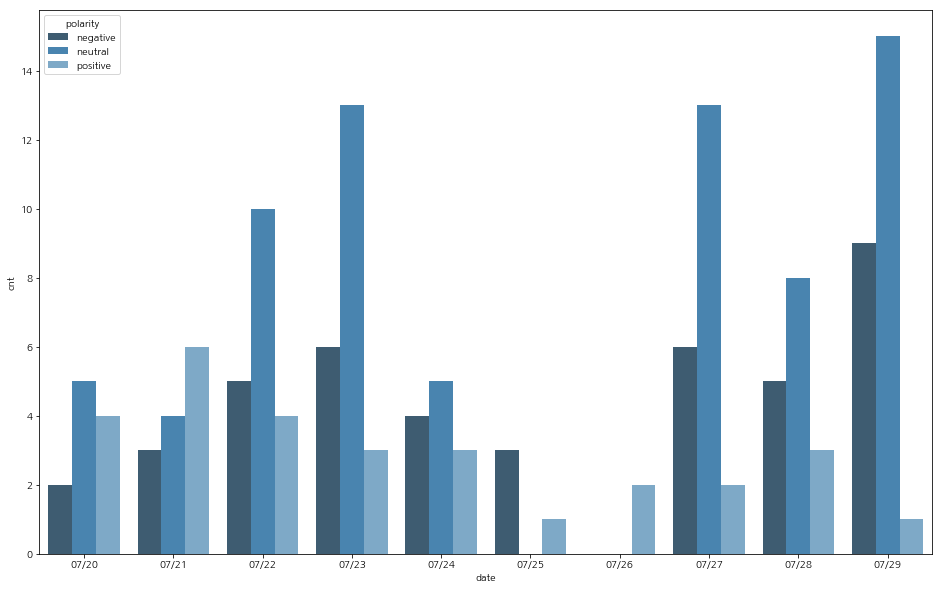

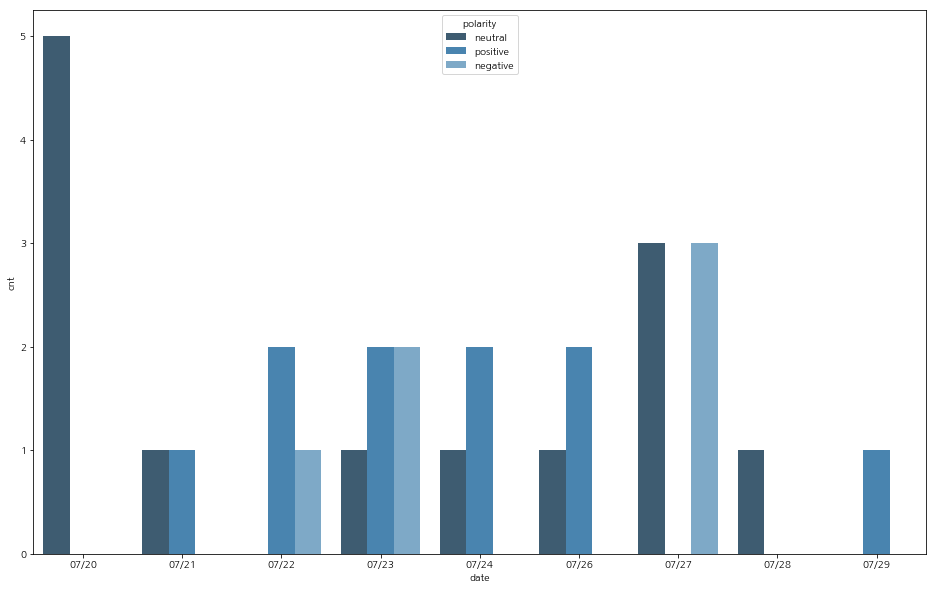

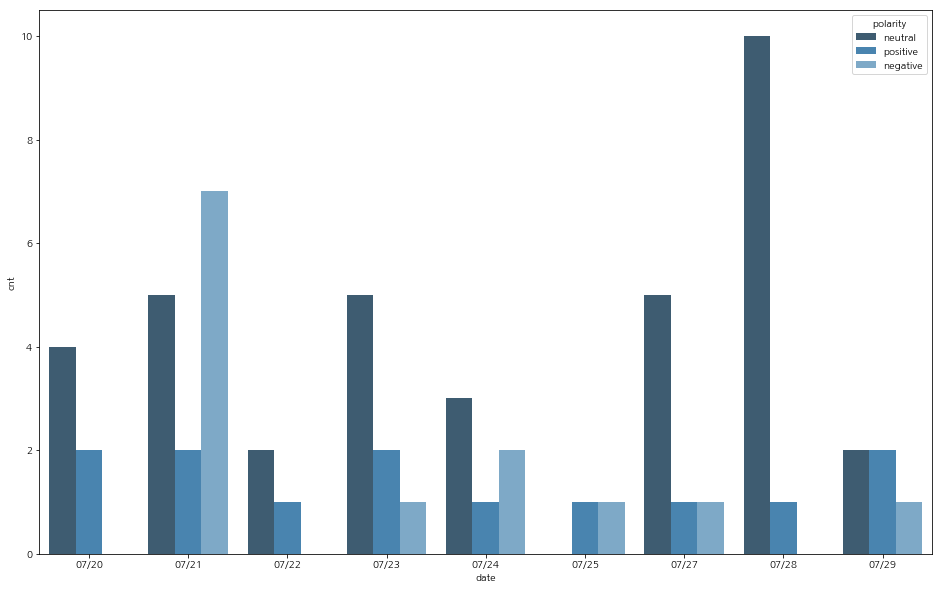

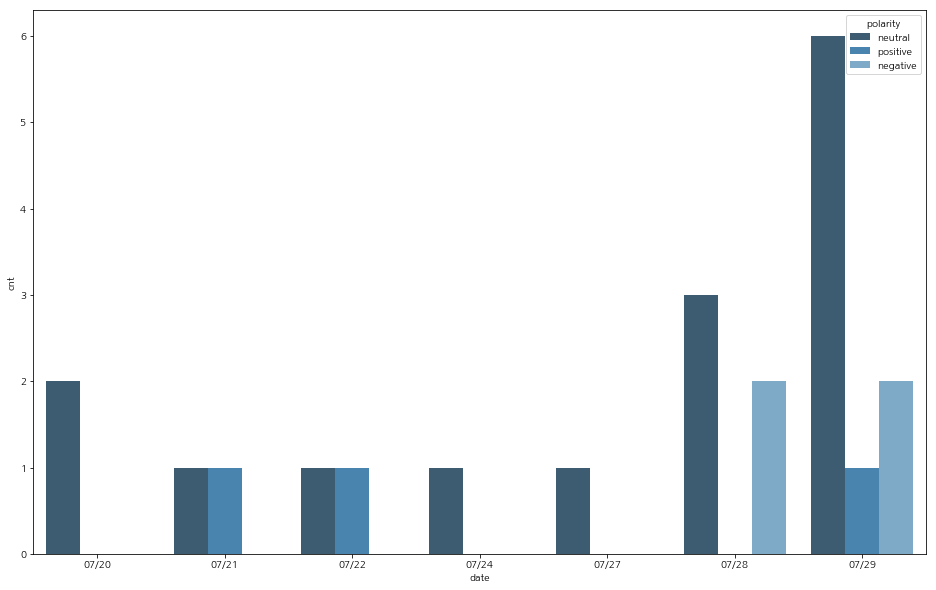

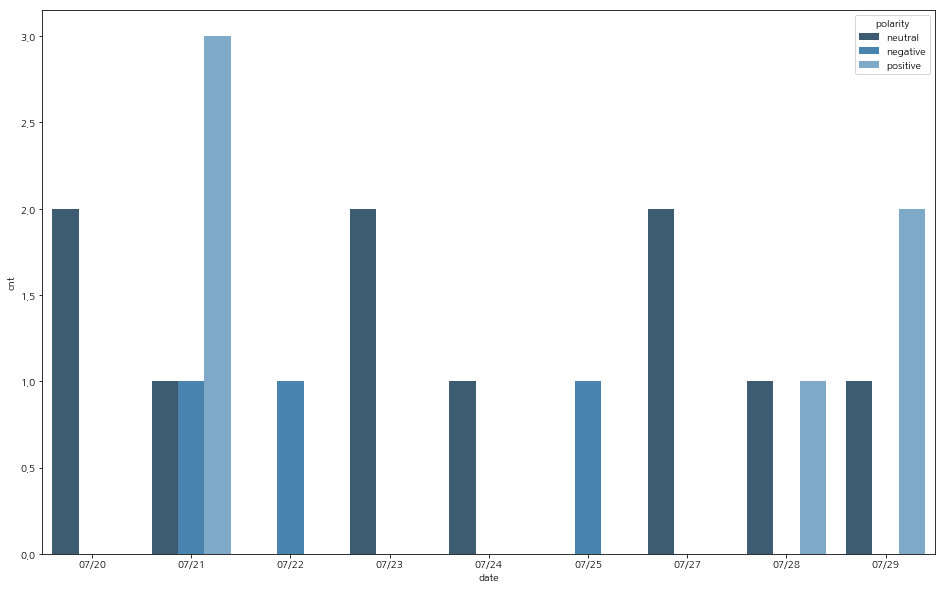

In [347]:
htmlcard=''
newscard=''
stockcard=''
for stk in stock_lists:
    ss = f'select pubdate, title, url, summary,score, host from nutch_ext where {stk} is NOT NULL '
    
    conn = hive.Connection(host ='daou-bd-r01a01', port = 10000)
    cursor = conn.cursor()
    cursor.execute(ss)
    news_coll = cursor.fetchall()
    news_list = [{selectedcol[i] : a[i] for i in range(len(a))} for a in news_coll ]
    news_list = [{ k: datetime.datetime.strptime(v, "%Y%m%d%H%M%S") if k == 'pubdate' else v for k,v in x.items()} for x in news_list]
    news_list =  [dict(item, **{'name':stock_lists[stk]}) for item in news_list]
    news_list = sorted(news_list, key=lambda k: k['pubdate']) 
    
    
    #calcualte score
    scoresss = [float(a['score']) for a in news_list]
    q1 = np.percentile(scoresss,25)
    q3 = np.percentile(scoresss,75)
    
    #give polarity 
    for a in news_list:
        if float(a['score']) < q1:
            a['polarity'] = 'negative'
        elif float(a['score']) > q3:
            a['polarity'] ='positive'
        else:
            a['polarity'] = "neutral"
    
    make_polplot(news_list)
        
    recent10= sorted(news_list, key=lambda d: d['pubdate'], reverse=True)[:10]
    for r in recent10:
        r['pubdate'] = r['pubdate'].strftime('%B %d %Y')
        
        
    nownow = datetime.datetime.today().strftime('%B %d %Y')
    newsboxhtml = ''
    for a in recent10:
        STK = stk.upper()
        url = a['url']
        title = a['title']
        summary = a['summary']
        host = a['host']
        pubdate = a['pubdate']
        name = a['name']
        polarity= a['polarity']
        if polarity =='negative':
            color='#FF0000'
        elif polarity=='positive':
            color='#25BF00'
        else:
            color='#D1D1D1'
            
            
        newscardtp = f"""<div class="card">
                    <div class="titlesearch"><a href=\"{url}\">{title}</a></div>
                    <div class="textsearch">{summary}</div>
                    <div style="float:left;"><span class="bottomticker">{STK}</span><span class="bottomsearchtext"> {host} | {pubdate} </span></div>
                    <div style="text-align:right;"><span style="font-size:0.9rem;color:{color}; line-height:1rem ">{polarity}</span></div>
                </div>"""
        
        newscard += newscardtp
        
       
    stockcardtp =f"""  <div style="font-family:Helvetica;font-size:16px;background-color:#E9FCFC;display: inline-block;">{name}</div>
                            <div class="cardbox">
                                <div class="card-items">
                                                        {newscard}

                                                    </div>
                            </div>

                            <div><br><hr style="width=80%;size=1px;opacity:0.2; background-color:#D3D3D3;border: 0 ;"/></div>"""
    stockcard +=stockcardtp


In [63]:
 
newsectionhtml=f"""<div style="text-align: center; inline-block">{stockcard}
                            </div>"""


In [348]:
TEMPLATE = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">
        <meta name="viewport" content="width=device-width, initial-scale=1">
        <meta name="description" content="Get the latest stock news from the best news sources. Use our API to get relevant video and article content from companies in the stock market.">
        <meta name="keywords" content="stock news api, news api, news api headlines, stock api">
        <!-- Schema.org for Google -->
        <meta itemprop="name" content="Stock News API - A JSON API for stock market article and video news">
        <meta itemprop="description" content="Get the latest stock news from the best news sources. Use our API to get relevant video and article content from companies in the stock market.">
        <link rel="canonical" href="https://stocknewsapi.com/">
        <!-- CSRF Token -->
        <meta name="csrf-token" content="lxiwXBy57VJ2w4a8UmljM5U05mA2eK9xPdmMy8KI">
        <title>Stock News API - A JSON API for stock market news</title>
        <!-- Scripts -->
        <script src="https://stocknewsapi.com/js/scrollreveal.min.js"></script>
        <!-- Fonts -->
        <link href="https://fonts.googleapis.com/css?family=Lato:400,400i|Roboto:500" rel="stylesheet">
        <link href="https://fonts.googleapis.com/css?family=Fjalla+One&display=swap" rel="stylesheet">
        <link href="https://fonts.googleapis.com/css?family=Open+Sans&display=swap" rel="stylesheet">
        <!-- Styles -->
        <link href="https://stocknewsapi.com/css/stylelanding.css?v=2.3" rel="stylesheet">
        <link href="https://stocknewsapi.com/css/prims.css" rel="stylesheet">
        <!-- Global site tag (gtag.js) - Google Analytics -->
        <script async src="https://www.googletagmanager.com/gtag/js?id=UA-121402530-2"></script>


    </head>
    <body style="background:#F6F8FA; margin:0 auto;">
        <div class="body-wrap" style="max-width:80%; margin:auto;">
            <div class="top-bar"></div>
            <header style="margin-top:10px; margin-bottom:20px; position:relative; padding:15px 0 15px; ">
                <div class="container">
                    <div class="site-header-inner">
                        <div class="brand header-brand">
                            <h1 class="m-0">

                                <img src=https://github.com/Irenejy93/daouHTMLimg/blob/master/polarity_AMZN.png?raw=true"  width="200px" height="70px" alt="Stocknewsapi Logo">

                            </h1>
                        </div>
                        <div class="margin-right: 0">
                        </div>
                    </div>
                </div>
            </header>
           <main>
                <section id="demo" class="hero text-center">
                    <div class="container-sm">
                       
                            <h1 class="hero-title h2-mobile mt-0 is-revealing">DAOU DAILY STOCK</h1>


                            <div class="hero-paragraph is-revealing">
                                Latest news for the large capital companies from the reliable news sources. News are given with their keywords, summary and polarity

                            </div>




                    <div class="container">
                        <div class="features-inner section-inner">
                            <div class="features-wrap">



                                <div class="feature-icon" style="padding:0px 20px 0px 40px">
                                    <img src="https://image.flaticon.com/icons/svg/3003/3003561.svg" width="55px" height="55px" alt="Clean Data" style="display: inline-block;">
                                </div>

                                <div class="feature-icon" style="padding:0px 20px 0px 40px">
                                    <img src="https://image.flaticon.com/icons/svg/966/966251.svg" width="55px" height="55px" alt="Clean Data" style="display: inline-block;">
                                </div>

                                <div class="feature-icon" style="padding:0px 20px 0px 40px">
                                    <img src="https://image.flaticon.com/icons/svg/1534/1534136.svg" width="55px" height="55px" alt="Clean Data" style="display: inline-block;">

                                </div>

                                <div class="feature-icon" style="padding:0px 20px 0px 40px">
                                    <img src="https://image.flaticon.com/icons/svg/1808/1808958.svg" width="60px" height="60px" alt="Clean Data" style="display: inline-block;">
                                </div>



                            </div>
                        </div>
                    </div>

    <div> <br></div>
{newsectionhtml}

</div>

                </section>
            </main>
            
            
                 <section>
                <footer class="site-footer text-light">
                <div class="container">
                    <div class="site-footer-inner">
                        <div class="brand footer-brand" style="margin-top: 30px">
                            &nbsp;
                        </div>
                        <ul class="footer-links list-reset">

                            <li>
                                <a href="/contact">irenee.jy93@gmail.com</a>
                            </li>
                        </ul>
                        <ul class="footer-social-links list-reset">

                        </ul>
                        <div class="footer-copyright">Updated on {nownow} </div>
                    </div>
                </div>
                </footer>





            </section>


        </div>

        <!-- The Modal -->
        <div id="recaptcha-modal" class="custom-modal">
            <!-- Modal content -->
            <div class="modal-content">
                <span class="close">&times;</span>
                <script src="https://www.google.com/recaptcha/api.js?" async defer></script>

                <div data-callback="recaptchaCallback" data-sitekey="6Ldf_qYUAAAAAOKckxSfQtl2XT-W_HwFvd3PQO6J" class="g-recaptcha"></div>
            </div>
        </div>

        <script src="https://stocknewsapi.com/js/main.min.js"></script>

        <script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/3.3.1/jquery.min.js"></script>
        <script src="/build/admin-assets/vendor/jQuery-autoComplete/jquery.auto-complete.min.js"></script>
        <link href="/build/admin-assets/vendor/jQuery-autoComplete/jquery.auto-complete.css" rel="stylesheet">

    <!-- Start of HubSpot Embed Code -->
      <script type="text/javascript" id="hs-script-loader" async defer src="//js.hs-scripts.com/5490784.js"></script>
    <!-- End of HubSpot Embed Code -->

    <script src="https://stocknewsapi.com/js/jquery-1.10.2.min.js"></script>
    <script src="https://stocknewsapi.com/js/numscroller-1.0.js"></script>
    <script src="https://stocknewsapi.com/js/prism.js"></script>

    <!-- Chart JS -->
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/2.9.3/Chart.min.css">
    <script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/2.9.3/Chart.min.js" async></script>

    </body>
    </html>
    """  


In [349]:
print(TEMPLATE)


    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">
        <meta name="viewport" content="width=device-width, initial-scale=1">
        <meta name="description" content="Get the latest stock news from the best news sources. Use our API to get relevant video and article content from companies in the stock market.">
        <meta name="keywords" content="stock news api, news api, news api headlines, stock api">
        <!-- Schema.org for Google -->
        <meta itemprop="name" content="Stock News API - A JSON API for stock market article and video news">
        <meta itemprop="description" content="Get the latest stock news from the best news sources. Use our API to get relevant video and article content from companies in the stock market.">
        <link rel="canonical" href="https://stocknewsapi.com/">
        <!-- CSRF Token -->
        <meta name="csrf-token" content="lxiwXBy57VJ2w4a8Uml

In [350]:

TEMPLATE = TEMPLATE.replace('\n','')

In [78]:
with open('temp','w') as pf:
    pf.write(TEMPLATE)

In [351]:



msg = MIMEText(
    Environment().from_string(TEMPLATE).render(
        title='Hello World!'
    ), "html"
)

subject = "help!!"
sender= "irenee.jy93@daou.co.kr"
recipient ="irenee.jy93@daou.co.kr"

msg['Subject'] = subject
msg['From'] = sender
msg['To'] = recipient

# Send the message via our own local SMTP server.
s = SMTP('localhost')
s.sendmail(sender, [recipient], msg.as_string())
s.quit()

(221, b'2.0.0 Bye')

In [ ]:
### 시간별 정렬 

In [56]:
TEMPLATE

'<!DOCTYPE html>    <html lang="en">    <head>        <meta charset="utf-8">        <meta http-equiv="X-UA-Compatible" content="IE=edge">        <meta name="viewport" content="width=device-width, initial-scale=1">        <meta name="description" content="Get the latest stock news from the best news sources. Use our API to get relevant video and article content from companies in the stock market.">        <meta name="keywords" content="stock news api, news api, news api headlines, stock api">        <!-- Schema.org for Google -->        <meta itemprop="name" content="Stock News API - A JSON API for stock market article and video news">        <meta itemprop="description" content="Get the latest stock news from the best news sources. Use our API to get relevant video and article content from companies in the stock market.">        <link rel="canonical" href="https://stocknewsapi.com/">        <!-- CSRF Token -->        <meta name="csrf-token" content="lxiwXBy57VJ2w4a8UmljM5U05mA2eK9xPdmM